# String Method Analysis Markov-State-Models
## Imports

In [1]:
import os
import pickle
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt


logging.getLogger("stringmethod").setLevel(logging.ERROR)
sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

['/data2/GLUT5_string/string/analysis/scripts', '/home/semccomas/anaconda3/envs/string_method/lib/python38.zip', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/lib-dynload', '', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages', '../../string-method-gmxapi/', '../../string-method-gmxapi/stringmethod/simulations/../../']


## Load data
<a id='top'></a>


This notebook needs to run in the string simulation folder, this cell will get you there. You also set up a path for writing the figures.

In [2]:
name_sim = "influx_apo_gate_CV"
simulation_directory = f"/data2/GLUT5_string/string/string_sims/TMD_initial_path/{name_sim}"
path_report = f"/data2/GLUT5_string/string/analysis/images_figs/MSM_FES/IC_EC_MSM/{name_sim}"
os.chdir(simulation_directory)
os.getcwd()

'/data2/GLUT5_string/string/string_sims/TMD_initial_path/influx_apo_gate_CV'

In [3]:
with open("cv.pkl", "rb") as file:
    cvs, ndx_groups = pickle.load(file)

The `load_swarm_data` function will load the swarm data in the `cv_coordinates`. If you set `extract=True` it will read the data from the swarm files. If you have done this previously you can set `extract=False` so the function just reads `postprocessing/cv_coordinates.npy`. `first_iteration` can be used to exclude initial swarms as equilibration and `last_iteration` can be done to exclude some iterations for example if you want to estimate the FES convergence by comparing blocks of data.

In [4]:
first_iteration = 100
last_iteration = None
extract = False


if extract:
    cv_coordinates = my_msm.load_swarm_data(
    extract=extract, first_iteration=first_iteration, last_iteration=last_iteration
    )
    np.save('./cv_coordinates.final.MSM.npy', cv_coordinates)
else:
    cv_coordinates = np.load('./cv_coordinates.final.MSM.npy')
    

 <a id='dim'></a>


## Dimensionality reduction with TICA


The following cell computes the tica projection of the string cvs and discards the tics that have the lowest kinetic variance. This reduces the cvs space to a lower dimensional space that is adapted to the kinetic variance. You can use the drop keyword to drop certain cvs that are not well converged in the string simulation or that change very little from the beggining to the end of the string. The best case scenario is that `drop=[]` just works.

In [5]:
tica = my_msm.cvs_to_tica(cv_coordinates, drop=[])#20, 21, 22, 23, 32, 33, 34, 35])

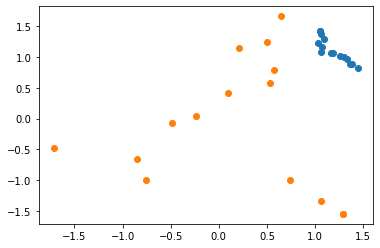

In [6]:
refs = [0, 31, 62, 93, 124, 155, 186, 217, 248, 279, 310, 341, 372, 403, 434]
#refs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
plt.scatter(cv_coordinates[refs,0,1], cv_coordinates[refs,0,0])
plt.scatter(tica[refs,0,1], tica[refs,0,0])


## Cluster

The next cell plots the "vamp score" of using `n_clustercenters` to make an MSM. You should find that at some point the vamp score saturates. Choose the minimum number of clusters that gives you the saturated vamp score as the value of k for the next steps. This might take a little while.

/data2/GLUT5_string/string/analysis/scripts/string_tica_msm.py:85: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loop over k::   0%|          | 0/8 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/deeptime/clustering/_kmeans.py:435: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

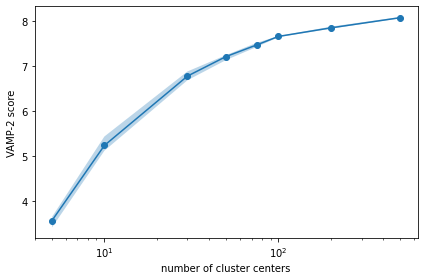

In [7]:
n_clustercenters = [5, 10, 30, 50, 75, 100, 200, 500][::-1]
fig, ax = my_msm.get_vamp_vs_k(n_clustercenters, tica)

In [8]:
cv_coordinates_backup = cv_coordinates
split_by_bead = False

If the calculation fails, there is something wrong with your MSM. Either you have too little transitions or there too many cvs in tica to have all the states well connected. Solutions:
+ Reduce the maximum number of clusters (drop 200 and 500) of `n_clustercenters` and see if you get a saturated curve.
+ Reduce the number of cvs that went into your TICA calculation.
+ Do more iterations of the string method.

## MSM Deeptime

Choose the number of clusters, `k`, for the clustering from the previous calculation. Also change n_proc to however many processors you can use.

In [9]:
k = 100
clusters = my_msm.k_means_cluster(
    tica, k, stride=1, max_iter=500, n_proc=8, seed=28101990
)

In [10]:
%%time
msm, weights = my_msm.get_msm(clusters)

CPU times: user 33.3 s, sys: 1.42 s, total: 34.7 s
Wall time: 35.8 s


In [11]:
np.save('./weights_MSM.npy', weights)

In [12]:
#plt1 = plt.hist(weights, bins = 'auto')
#f = plt.figure(figsize=(10,3))
#_ = plt.hist(np.ravel(p_of_cv), bins = 'auto')


In [13]:
np.shape(cv_coordinates)

(289408, 2, 2)

## CVs for projection

Make a `cv_proj` numpy array with shape (n_iteration * n_swarms_iterations, n_frames_per_iter, 2). n_frames_per_iter is usally 2 since you only record the value of the cvs at the begining and end of the swarm. The last dimesions are the cvs on which you would like to project your FES using the weights obtained from the msm. The FES is then the negative log of a *weighted* histogram of the projection cvs using the weights from the msm. The projection cvs can be anything that you can calculate for a structure, not necessarily the cvs of the string. In the example bellow it is the mean of two cvs.

Choose one of these to run:

Option 1: gate CVs

In [14]:
darko = False
my_cvs = [1,0] #IC gate, EC gate
cv_proj = cv_coordinates[:, :, my_cvs]
cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

## load atomisitic models and sim endpoints to compare to projection. 
###### this is not required to run, so skip if you want to add the points on top

In [15]:
def get_G5_atomistic_gate(timestep):
    # get all pieces together, then colors and naming consistent in plots
    G5_Out = np.array(['OUT', 'Out Open', 'green', "Greens"])
    G5_OutOcc = np.array(['OUT-OCC', 'Out Occ.', 'grey', "Greys"])
    G5_Occ = np.array(['OCC', 'Occluded', 'red', "Reds"])
    G5_InOcc = np.array(['IN-OCC', 'In Occ.', 'orange', "Oranges"])
    G5_In = np.array(['IN', 'In Open', 'blue', "Blues"])
    all_sims = np.array([G5_Out, G5_OutOcc, G5_Occ, G5_InOcc, G5_In])

    indir = '/data2/GLUT5_string/string/analysis/textfiles_out/EC_IC_gate_refs'

 
    out_arr = []
    for n, sim in enumerate(all_sims):
        name = sim[0]
        ec = np.loadtxt(f"{indir}/{name}.EC.{timestep}.xvg")[1]
        ic = np.loadtxt(f"{indir}/{name}.IC.{timestep}.xvg")[1]
        
        
        temp = np.append(all_sims[n], [f'EC: {str(ec)}', f'IC: {str(ic)}'])
        out_arr.append(temp)

    out_arr = np.array(out_arr)
    return out_arr

In [16]:
plot_atomistic = True
name = 'start_model'
#name = 'end_atom'
atom_sims = get_G5_atomistic_gate(name)

In [17]:
plot_nandan_tatjana = False

In [18]:
if plot_nandan_tatjana:
    import glob 
    from matplotlib import cm
    viridis = cm.get_cmap('viridis', 20)
    gates_all = []
    labels_model_dirs={}
    colors_model_dirs={}
    if plot_nandan_tatjana:
        for n, model_dir in enumerate(glob.glob('../../../analysis/nandan_tatjana/GLUT5/No*')):
            p1=int(model_dir.split('_')[3])
            p2=int(model_dir.split('_')[4])
            for x in np.arange(0,100):
                for y in np.arange(p1, p2):
                    ec = np.loadtxt(f'{model_dir}/EC/{x}_{y}.xvg')[1]
                    ic = np.loadtxt(f'{model_dir}/IC/{x}_{y}.xvg')[1]
                    gates_all.append([ec,ic,n])
                    print(ec,ic,n,'-', x,y)
            labels_model_dirs[n]= f'{p1}_{p2}'
            colors_model_dirs[n]=viridis(range(20)[n])
    gates_all = np.array(gates_all)

## Project FES

Do the projection and take log. You have to choose a bandwidth for the [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) of the histogram. It should be big enough to reduce noise but not so big to remove features. If you give `None`

In [19]:
bandwidth = 0.05
p_of_cv, extent = my_msm.get_kde(cv_proj, weights, bandwidth)
F0 = -np.log(p_of_cv)
F = F0 - F0.min()
F[F > 40] = np.nan

/tmp/ipykernel_23099/3473243697.py:3: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(p_of_cv)


In [20]:
np.save('./F_MSM.npy', F)
np.save('./extent_MSM.npy', extent)
np.save('./cv_proj_MSM.npy', cv_proj)

In [21]:
skip_calcs = False
if skip_calcs:
    F = np.load('./F_MSM.npy')
    extent = np.load('./extent_MSM.npy')
    cv_proj = np.load('./cv_proj_MSM.npy')
    last_iteration = None
    first_iteration = 100

## Plot FES

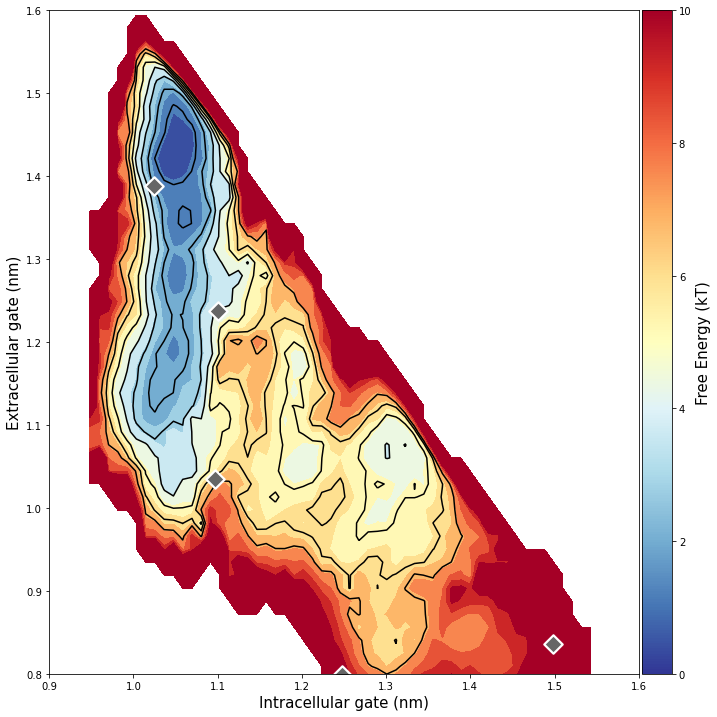

In [22]:
f_max = 10
cm = plt.cm.get_cmap('RdYlBu_r')

if last_iteration == None:
    last_iteration_n = "final"
else:
    last_iteration_n = last_iteration
fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    cmap=cm,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= xlim,
    ylim= ylim,
    colorbar=True
)

fig.tight_layout()

if f_max == 20:
    ax.contour(F, vmin=0, vmax=f_max, extent=extent, colors = 'black', levels = [0,1,2,3,5,8,10,13,16,19])
else:
    ax.contour(F, vmin=0, vmax=f_max, extent=extent, colors = 'black', levels = [0,1,2,3,4,5,6,7])

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

if plot_atomistic:
    for n in atom_sims:
        ic = float(n[-1].split(' ')[1])
        ec = float(n[-2].split(' ')[1])
        ax.scatter(ic, ec, color = ['#666666'], edgecolor = 'white', \
                   s = 170, zorder=2, marker='D', linewidth = 2.2)
        
        fig.savefig(path_report + \
                f"/structure_snapshots/FES_cutoff{f_max}.{name}.iteration{first_iteration}-{last_iteration_n}.png")

        
if plot_nandan_tatjana:
    for n,g in enumerate(gates_all):
        if g[2]:
            if n==0 or g[2]!=gates_all[n-1][2]:
                ## label first instance
                ax.scatter(g[1], g[0], s = 10, color=colors_model_dirs[int(g[2])], label=labels_model_dirs[int(g[2])])
            else:
                ## no label
                ax.scatter(g[1], g[0], s = 10, color=colors_model_dirs[int(g[2])])
    ax.legend()

    fig.savefig('../../../analysis/nandan_tatjana/GLUT5/all.svg')


In [38]:
np.shape(F)

(55, 55)

In [36]:
IC_extent

array([0.937159  , 0.94904069, 0.96092237, 0.97280406, 0.98468574,
       0.99656743, 1.00844911, 1.0203308 , 1.03221248, 1.04409417,
       1.05597585, 1.06785754, 1.07973922, 1.09162091, 1.10350259,
       1.11538428, 1.12726596, 1.13914765, 1.15102933, 1.16291102,
       1.1747927 , 1.18667439, 1.19855607, 1.21043776, 1.22231944,
       1.23420113, 1.24608281, 1.2579645 , 1.26984619, 1.28172787,
       1.29360956, 1.30549124, 1.31737293, 1.32925461, 1.3411363 ,
       1.35301798, 1.36489967, 1.37678135, 1.38866304, 1.40054472,
       1.41242641, 1.42430809, 1.43618978, 1.44807146, 1.45995315,
       1.47183483, 1.48371652, 1.4955982 , 1.50747989, 1.51936157,
       1.53124326, 1.54312494, 1.55500663, 1.56688831, 1.57877   ])

In [28]:
fmax_test = 15

IC_extent = np.linspace(extent[0], extent[1], 55)
EC_extent = np.linspace(extent[2], extent[3], 55)


IC_test = []
EC_test = []


for val_IC, val_EC in zip(IC_extent[np.where(F < fmax_test)[1]], EC_extent[np.where(F < fmax_test)[0]]):
    print(np.round(val_IC,2), np.round(val_EC,2))
    IC_test.append(val_IC)
    EC_test.append(val_EC)

1.28 0.8
1.29 0.8
1.31 0.8
1.32 0.8
1.33 0.8
1.34 0.8
1.35 0.8
1.36 0.8
1.38 0.8
1.39 0.8
1.4 0.8
1.41 0.8
1.42 0.8
1.44 0.8
1.45 0.8
1.46 0.8
1.47 0.8
1.48 0.8
1.5 0.8
1.51 0.8
1.52 0.8
1.53 0.8
1.25 0.81
1.26 0.81
1.27 0.81
1.28 0.81
1.29 0.81
1.31 0.81
1.32 0.81
1.33 0.81
1.34 0.81
1.35 0.81
1.36 0.81
1.38 0.81
1.39 0.81
1.4 0.81
1.41 0.81
1.42 0.81
1.44 0.81
1.45 0.81
1.46 0.81
1.47 0.81
1.48 0.81
1.5 0.81
1.51 0.81
1.52 0.81
1.53 0.81
1.54 0.81
1.56 0.81
1.57 0.81
1.58 0.81
1.22 0.83
1.23 0.83
1.25 0.83
1.26 0.83
1.27 0.83
1.28 0.83
1.29 0.83
1.31 0.83
1.32 0.83
1.33 0.83
1.34 0.83
1.35 0.83
1.36 0.83
1.38 0.83
1.39 0.83
1.4 0.83
1.41 0.83
1.42 0.83
1.44 0.83
1.45 0.83
1.46 0.83
1.47 0.83
1.48 0.83
1.5 0.83
1.51 0.83
1.52 0.83
1.53 0.83
1.54 0.83
1.56 0.83
1.57 0.83
1.58 0.83
1.17 0.84
1.2 0.84
1.21 0.84
1.22 0.84
1.23 0.84
1.25 0.84
1.26 0.84
1.27 0.84
1.28 0.84
1.29 0.84
1.31 0.84
1.32 0.84
1.33 0.84
1.34 0.84
1.35 0.84
1.36 0.84
1.38 0.84
1.39 0.84
1.4 0.84
1.41 0.84
1.42 0.84


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
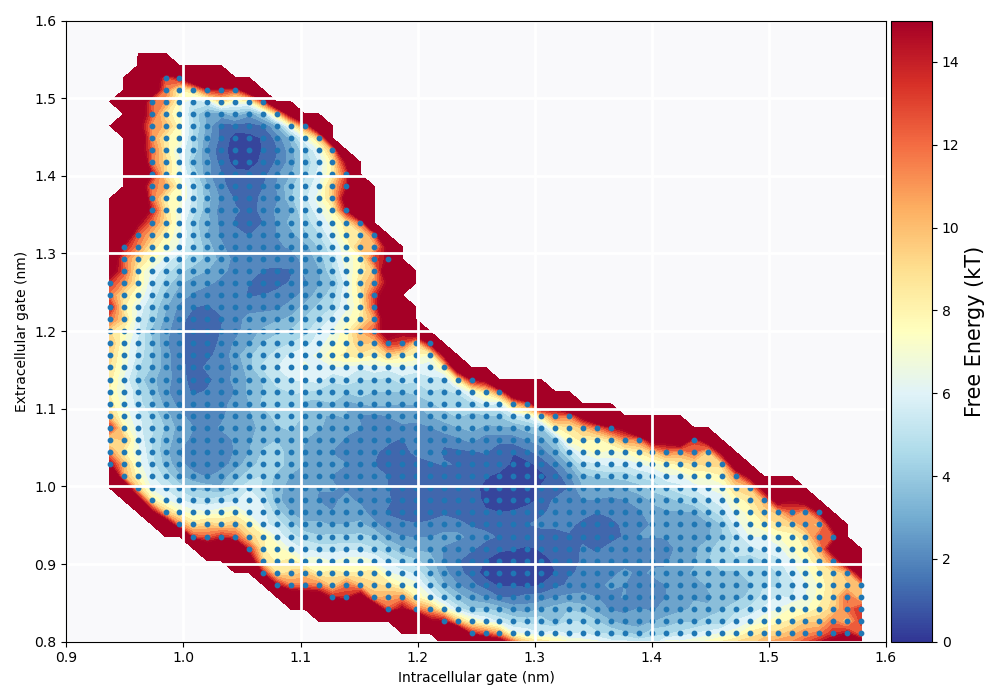

In [35]:
f_max = fmax_test

if last_iteration == None:
    last_iteration_n = "final"
else:
    last_iteration_n = last_iteration
fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= xlim,
    ylim= ylim
)

fig.tight_layout()


ax.scatter(IC_test, EC_test, s = 10)

'/data2/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV'

## Bootstrap to get error

The problem with calculating errors in MD is that most statistical techniques for this rely on the data being uncorrelated. MD data is most of the time highly correlated due to the proximity in time and starting structure. Correlated data generates artificially low error estimates. 

For this reason we use blocking. In our case we will use blocking+bootstrapping. This is very well explained in this [very usefull video](https://www.youtube.com/watch?v=gHXXGYIgasE&t=1854s) by prof. Giovanni Bussi.

The uncertainty is calculated as half of the interval containing 95% of the probability of the distribution of histograms generated in the bootstraps.

This part is probably going to be slow! Maybe it will go over night. It is actually doing len(blocks) * n_boot msms! The good things is that once you have figured out for your system (and similar systems) what is a reasonable number of blocks then you can just do `blocks=[my_reasonable_number_blocks]`.

In [31]:
blocks =[2, 4, 8, 16, 32]
#blocks = [4] #after testing BFRU, let's start with highest error block
errors = my_msm.get_error(
    cv_proj,
    clusters,
    extent,
    n_boot=200,
    bandwidth=0.05,
    nbin=55,
    blocks=blocks
)

Loop over blocks:   0%|          | 0/5 [00:00<?, ?it/s]

Loop over bootstraps:   0%|          | 0/200 [00:00<?, ?it/s]

/data2/GLUT5_string/string/analysis/scripts/string_tica_msm.py:249: RuntimeWarning: invalid value encountered in true_divide
  errors.append((hdi[1, :, :] - hdi[0, :, :]) / 2 / x_mean)


Loop over bootstraps:   0%|          | 0/200 [00:00<?, ?it/s]

/data2/GLUT5_string/string/analysis/scripts/string_tica_msm.py:249: RuntimeWarning: divide by zero encountered in true_divide
  errors.append((hdi[1, :, :] - hdi[0, :, :]) / 2 / x_mean)


Loop over bootstraps:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over bootstraps:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over bootstraps:   0%|          | 0/200 [00:00<?, ?it/s]

In [32]:
np.save("postprocessing/errors.npy", errors)

In [33]:
np.shape(errors)

(5, 55, 55)

Choose the number of blocks that gives you a high error.

Note,`e_min` and `e_max` are choosen to remove the extremely high or low values of error that are generated due to poor sampling or high free energy. These regions of the "free error surface" are not what we care about and thus we remove it from the statistic and the visualization.

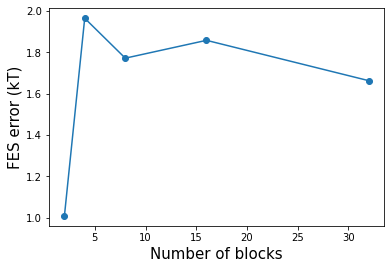

In [34]:
e_max = 6
e_min = 1.0e-03
e = errors.copy()
e[e > e_max] = np.nan
e[e <= e_min] = np.nan
_ = plt.plot(np.array(blocks), np.nanmean(e, axis=(1, 2)), marker="o")
_ = plt.xlabel("Number of blocks", size=15)
_ = plt.ylabel("FES error (kT)", size=15)

From the previous plot you can see which is the adequate number of blocks that low but still gives you the plateauing (or highest) error.

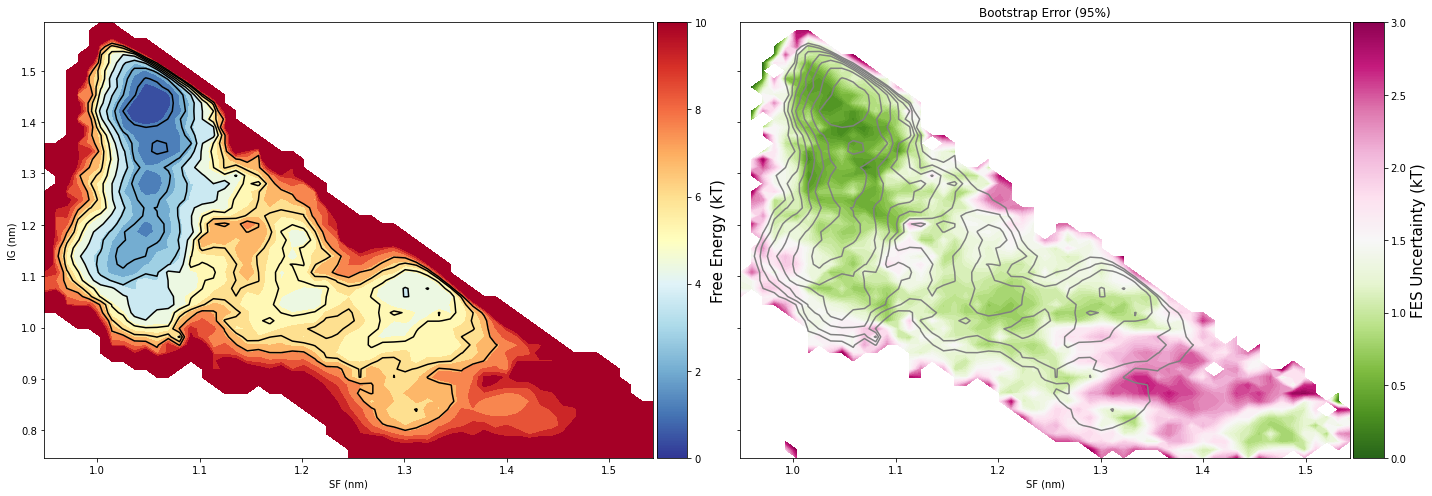

In [35]:
number_blocks = 4
f_max = 20
e_max = 3
e_min = 1.0e-03

e = errors[blocks.index(number_blocks)].copy()
e[e > e_max] = np.nan
e[e <= e_min] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(10 * 2, 7), sharex=True, sharey=True)
_ = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=10,
    cbar_label="Free Energy (kT)",
    xlabel="SF (nm)",
    ylabel="IG (nm)",
    fig=fig,
    ax=ax[0],
    colorbar=True
)
x = my_msm.plot_2D_heatmap(
    e,
    extent,
    f_max=e_max,
    cbar_label="FES Uncertainty (kT)",
    xlabel="SF (nm)",
    cmap=plt.cm.PiYG_r,
    fig=fig,
    ax=ax[1],
    colorbar=True
)
ax[1].set_title("Bootstrap Error (95%)")
fig.tight_layout()


ax[0].contour(F, vmin=0, vmax=f_max, extent=extent, colors = 'black', levels = [0,1,2,3,4,5,6,7])
ax[1].contour(F, vmin=0, vmax=f_max, extent=extent, colors = 'grey', levels = [0,1,2,3,4,5,6,7])



#fig.colorbar(x)
fig.savefig(path_report + "FES_error.png")

 <a id='sarah'></a>


 <a id='sarah'></a>


 <a id='sarah'></a>


 <a id='sarah'></a>


# Sarah - getting graph points

back to [top](#top)

In [5]:
## if not already, start in the working directory of the simulation to get F_MSM etc
if name_sim not in os.getcwd():
    os.chdir(f'../../string_sims/TMD_initial_path/{name_sim}')

F = np.load('./F_MSM.npy')
extent = np.load('./extent_MSM.npy')
cv_proj = np.load('./cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)



# change back to scripts path so that we can use this for later postprocessing
os.chdir('../../../analysis/scripts')

#### First, plot heatmap in widget form so we can pan and zoom to grab a very specific region:

This is a very visual method, so a lot of trial and error is needed

2022-01-13 15:22:34 matplotlib.pyplot-DEBUG: Loaded backend module://ipympl.backend_nbagg version unknown.
2022-01-13 15:22:34 matplotlib.colorbar-DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fdb5a43bac0>
2022-01-13 15:22:34 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fdb5a43bac0> on colorbar
2022-01-13 15:22:34 matplotlib.colorbar-DEBUG: Setting pcolormesh
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeTwoSym' (STIXSiz

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstTitleL' (KacstTitleL.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Medium.ttc) normal normal 500 normal>) = 10.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 200 normal>) = 11.24
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXVariants' (STIXVariants-Regular.otf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) =

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsD' (STIXIntegralsD-Bold.otf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 500 normal>) = 10.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Bol

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 500 normal>) = 10.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 100 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Waree' (Waree-Bold.ttf) normal normal 700 norma

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Laksaman' (Laksaman-Italic.ttf) italic normal 400 normal>) = 11.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Padauk Book' (Padauk-bookbold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'OpenSymbol' (opens___.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUnicode-Italic.otf) italic normal 400 normal>) = 

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (S

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lohit Punjabi' (Lohit-Punjabi.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXNonUnicode' (STIXNonUnicode-BoldItalic.otf) italic normal 700 normal>) = 11.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Padauk' (Padauk.ttf) normal normal 400 normal>) = 10.05
2022

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Bold.otf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 500 normal>) = 11.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Lato' (Lato-Thin.ttf) normal normal 200 normal>) = 10.24
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXVariants' (STIXVariants-Bold.otf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) it

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 no

2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 500 normal>) = 10.145
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: score(<Font 'STIXIntegralsSm' (STIXIntegralsSm-Bold.otf) normal normal 700 normal>) = 10.335
2022-01-13 15:22:34 matplotlib.font_manager-DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/ma

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
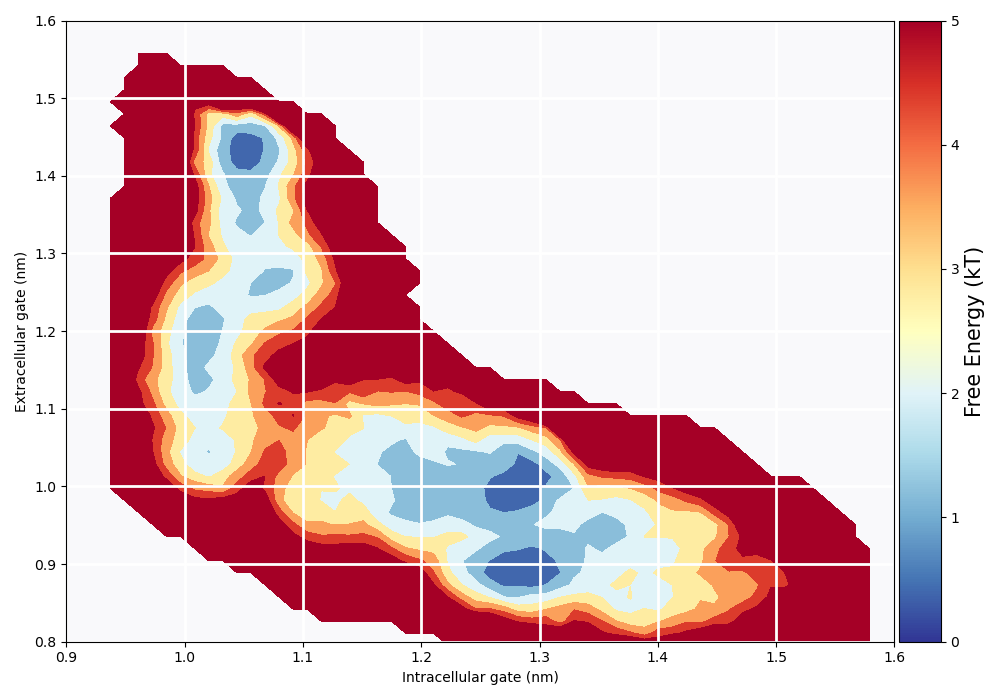

In [6]:
%matplotlib widget
f_max = 5


fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= xlim,
    ylim= ylim
)



fig.tight_layout()
plt.show()

#### Add all the squares we want to have to this dictionary so it's easy to keep track of what squares we are taking. 
This will also be used to define the directories later on in which we will keep the relevant confout files

**NOTE:** You may have to fine-tune this square a bit because the 55x55 grid is about 0.01 spaces apart, so please do check how the grid is looking on your energy surface and that you are satisfied with the grid points overlaid on the FES

Define both `grid_definitions` and `energy_space_on_grid` with same key variables. Values will be grid shape, and fmax and fmin


# attention!!! As we are now histogramming this entire dataset, we are going to want to streamline this process. I will make a .sh and a .py file which follows more or less the work below, but automated

We can still use this code for playing with certain squares but be aware that it may be different

In [7]:

grid_definitions = {"BFRU_transition_occ": [1.067, 1.093, 1.059, 1.076],
                   "BFRU_out_open": [1.035, 1.0683, 1.41, 1.455],
                    "BFRU_out_occ_well1":[1.056, 1.09, 1.25, 1.283],
                    "BFRU_out_occ_well3":[0.995, 1.042, 1.018, 1.075],
                    "apo_out_occ_well3":[1.03, 1.07, 1.02, 1.07],
                   "apo_out_open":[1.025, 1.075, 1.39, 1.47],
                   "apo_out_occ_well1":[1.038, 1.063, 1.255, 1.308],
                   "apo_transition_occ":[1.115, 1.145, 1.04, 1.10]}

energy_space_on_grid = {"BFRU_transition_occ":[3,4],
                       "BFRU_out_open": [0,0.8],
                       "BFRU_out_occ_well1":[1,1.7],
                        "BFRU_out_occ_well3":[0,2.3],
                        "apo_out_occ_well3":[0,4],
                       "apo_out_open":[-1,0.8],
                       "apo_out_occ_well1":[0.5, 1.5], 
                       "apo_transition_occ":[5.5,7],
                       "all":[0,50]}

#grid = 'BFRU_transition_occ'
grid = 'all'
#IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost = grid_definitions[grid]

In [8]:
IC_extent = np.linspace(extent[0], extent[1], 55)
EC_extent = np.linspace(extent[2], extent[3], 55)

## reading grid left to right, then down a row and left to right again. No reason for this. 

x_grid_index = 20
y_grid_index = 20

#for y_grid_index in range(0, 55):
    #for x_grid_index in range(0,55):
        #print(x_grid_index, y_grid_index)

IC_leftmost = IC_extent[x_grid_index] - 0.01
IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
EC_lowermost = EC_extent[y_grid_index] - 0.01



print(IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost)

1.1647927037037038 1.1966743888888889 1.1320713333333332 1.096516222222222


This function will mask values for IC and EC inside this square

In [9]:
def get_square(data, IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost, IC_index, EC_index):
    '''
    IC index should be 0 or 1 depending on where it exists in data, same for EC
    '''
    
    col0m = np.logical_and(data[:,IC_index]>= IC_leftmost, data[:,IC_index]<=IC_rightmost) #IC column mask
    col1m = np.logical_and(data[:,EC_index]>= EC_lowermost, data[:,EC_index]<=EC_uppermost) #EC column mask

    col0_1 = data[col0m & col1m]
    
    IC_selected_region = col0_1[:,IC_index]
    EC_selected_region = col0_1[:,EC_index]
    
    return IC_selected_region, EC_selected_region

#### Then we will mask `F` to return only the values in the range between `min_F` and `max_F`. This is `all_min_vals`.
- If you want to be sure that you are plotting the correct range, just plot as this in the FES plot:
```
ax.scatter(all_mins_vals[:,0], all_mins_vals[:,1])
```
 

---

#### Then, take a specific square of all these values on the 55x55 grid, which becomes `all_min_vals_selected_region`
- This is however, on a 55x55 grid (based on the MSM calculations bandwidth) so it will not match the `cv_proj` just yet

In [10]:
min_F = energy_space_on_grid[grid][0]
max_F = energy_space_on_grid[grid][1]


IC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[1]
EC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[0]



#Return the IC&EC gate values where F is within specified range
IC_min_vals = []
EC_min_vals = []
for val_IC, val_EC in zip(IC_extent[IC_min_indices], EC_extent[EC_min_indices]):
    IC_min_vals.append(val_IC)
    EC_min_vals.append(val_EC)

all_min_vals = np.vstack((IC_min_vals, EC_min_vals)).T


IC_selected_region, EC_selected_region = get_square(data = all_min_vals,
                                                    IC_leftmost=IC_leftmost,
                                                    IC_rightmost=IC_rightmost,
                                                    EC_lowermost=EC_lowermost,
                                                    EC_uppermost=EC_uppermost,
                                                    IC_index=0,
                                                    EC_index=1)

all_min_vals_selected_region = np.vstack((IC_selected_region, EC_selected_region)).T

In [11]:
IC_selected_region

array([1.1747927 , 1.18667439, 1.1747927 , 1.18667439])

#### Use these minima in a designated square space (`all_min_vals_selected_region`) to find all values in `data` (`cv_proj` with removed first frame from the CV values) that are **close to** each point, specified by `margin`

The reason that we do this is that we don't want only those points on the minima but everything in that space. Here below is a picture example:
<img src="./images_for_jup/example_extract.png" style="height:300px"> 
Where:
* blue dots are `all_min_vals` between 3 - 4
* orange dots are `all_min_vals_selected_region`. Each of these is in `IC_region_bead` & `EC_region_bead` as shown below
* pink dots are then `all_nearby_minima_square`, as calulated below


You notice that the dots aren't perfect, but I think this is likely ok, it is still better than taking an entire square directly from `data` as this would include much more of the green (for this pic anyway)

In [149]:
margin = np.diff(IC_extent)[0]/2 + 0.001  #dist between each point + a bit extra

data = cv_proj[:,1,:] ## wondering if you need to only take the drift value of swarms, not starting...

all_nearby_minima_square = []
all_nearby_indices = []

for IC_region_bead, EC_region_bead in all_min_vals_selected_region:
    IC_nearby = np.logical_and(data[:,0]>(IC_region_bead-margin), data[:,0]<(IC_region_bead+margin))
    EC_nearby = np.logical_and(data[:,1]>(EC_region_bead-margin), data[:,1]<(EC_region_bead+margin))
    all_nearby_minima_square.append(data[IC_nearby & EC_nearby])
    all_nearby_indices.append(np.where(IC_nearby & EC_nearby)[0])
    
all_nearby_minima_square = np.array(all_nearby_minima_square)
all_nearby_minima_square = np.concatenate(all_nearby_minima_square)

all_nearby_indices = np.array(all_nearby_indices)
all_nearby_indices = np.concatenate(all_nearby_indices)

print(np.shape(all_nearby_minima_square))

(126, 2)


<ipython-input-149-e7892b0be4d9>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_minima_square = np.array(all_nearby_minima_square)
<ipython-input-149-e7892b0be4d9>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_indices = np.array(all_nearby_indices)


#### Lastly, check that your points you have chosen match the FES before taking the `confout` files

Reiterate the process until you are happy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
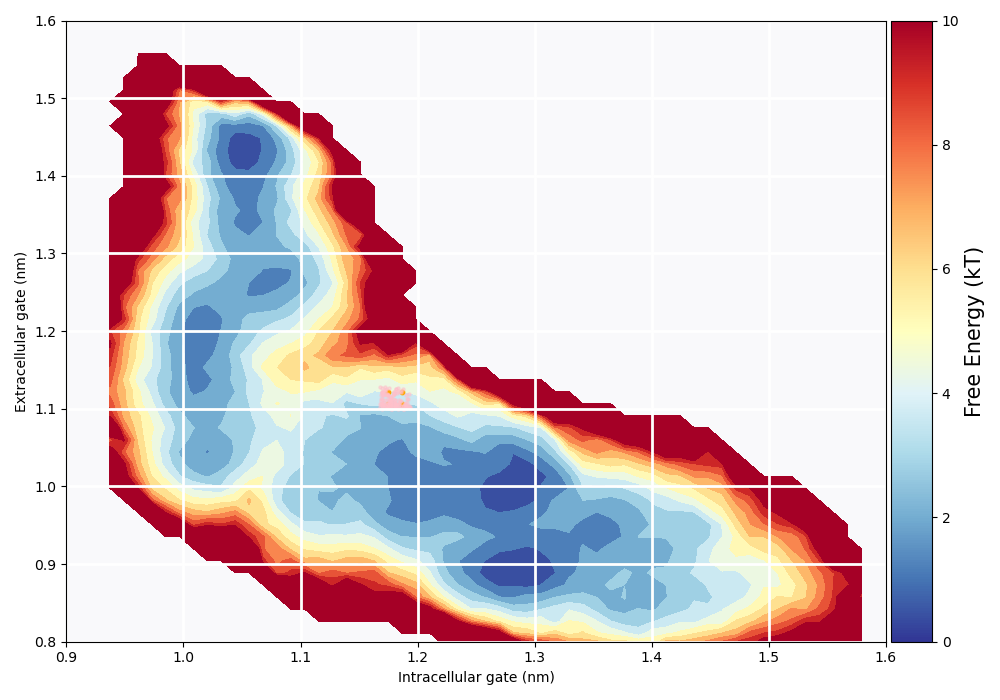

In [150]:
%matplotlib widget

f_max = 10


fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= xlim,
    ylim= ylim
)

fig.tight_layout()


#ax.scatter(all_min_vals[:,0], all_min_vals[:,1], s = 10)
ax.scatter(all_min_vals_selected_region[:,0], all_min_vals_selected_region[:,1], c = 'orange',s = 10)
ax.scatter(all_nearby_minima_square[:,0], all_nearby_minima_square[:,1], s = 5, alpha = 0.5, c = 'pink')

#### Once satisfied with `all_nearby_minima_square`, get original iteration, bead, swarm 


Ok, so now we have the values and indices for `data` where we have the specified box and minima (`all_nearby_minima_square` and `all_nearby_indices`). We will use this function from the `inflecs_string_sims` script to get original iteration, bead, swarm from these indices so we can do analysis on the confout files

Same as in the inflecs script, I will make a `.sh` script to get the confouts of all the simulations found from the function, and put them together for analysis

---
We will also trim the dataset if it's quite big, and remove duplicates. We don't need to have > 3000 points I think... You can choose the size to make your dataset by `size_cutoff`

In [53]:
def get_it_bead_swarm_from_index(index_number, iteration_start):
    #### divide index by 448 to find which iteration it's in
    iteration = int(np.floor(index_number / (n_swarms * n_beads))) 
    

    #### find which index this dictated iteration starts on
    iteration_start_string_index = (n_swarms * n_beads) * iteration  


    #### take the difference of the iteration start index and the actual index
    #### The difference between the actual index and iteration index / 32 will be which bead 
    bead = int(np.floor((index_number - iteration_start_string_index) / n_swarms)) 


    #### find which index this bead starts on
    #### will be iteration start + (1-448)
    bead_start_string_index = iteration_start_string_index + (n_swarms * bead)


    #### Get actual index - bead index start, max diff should be 31
    swarm = index_number - bead_start_string_index
    
    actual_iteration = iteration + iteration_start
    print(f"Returning iteration {actual_iteration}, bead {bead}, swarm {swarm}")
    
    
    #indir = f'../../../../string_sims/TMD_initial_path/{condition}/md'    
    if name_sim == 'influx_apo_gate_CV':
        indir = f'/mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/{name_sim}/md'
    if name_sim == 'influx_BFRU_gate_CV':
        indir = f'/mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/{name_sim}/md'
        
    confout_statement = f"{indir}/{actual_iteration}/{bead + 1}/s{swarm}/traj_comp.xtc"
    #print(f"Confout should be in: {confout_statement}")
    return actual_iteration, bead, swarm, confout_statement

In [54]:
n_swarms = 32
n_beads = 14

confout_list = []

for index in all_nearby_indices:
    iteration, bead, swarm, confout = get_it_bead_swarm_from_index(index, 100)
    confout_list.append(confout)
    print()


#take uniques and trim dataset    
confout_list = list(set(confout_list))
size_cutoff = 2000
if len(confout_list) > size_cutoff:
    slice_int = int(np.floor(len(confout_list) / float(size_cutoff)))
    confout_list = confout_list[::slice_int]

Returning iteration 110, bead 5, swarm 14

Returning iteration 116, bead 5, swarm 27

Returning iteration 172, bead 5, swarm 11

Returning iteration 173, bead 5, swarm 18

Returning iteration 174, bead 5, swarm 2

Returning iteration 174, bead 5, swarm 3

Returning iteration 174, bead 5, swarm 18

Returning iteration 218, bead 4, swarm 7

Returning iteration 218, bead 4, swarm 11

Returning iteration 228, bead 5, swarm 23

Returning iteration 233, bead 5, swarm 9

Returning iteration 234, bead 5, swarm 5

Returning iteration 235, bead 5, swarm 13

Returning iteration 236, bead 5, swarm 11

Returning iteration 236, bead 5, swarm 28

Returning iteration 237, bead 5, swarm 24

Returning iteration 239, bead 5, swarm 27

Returning iteration 240, bead 5, swarm 25

Returning iteration 241, bead 5, swarm 8

Returning iteration 244, bead 5, swarm 12

Returning iteration 254, bead 5, swarm 31

Returning iteration 255, bead 5, swarm 19

Returning iteration 266, bead 5, swarm 8

Returning iteratio

In [55]:
len(confout_list)

2208

In [28]:
confout_path=f'../confout_files/FES_grids_confouts/{name_sim}/{grid}'
if not os.path.isdir(confout_path):
    os.mkdir(confout_path)
logfile = open(f'{confout_path}/cluster_logs.txt', 'w')
trjcat_inflecs = open('./FES_grids_confouts_selection.sh', 'w')

trjcat_inflecs.write('#!/bin/bash')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -p tcb')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -J conf')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -t 03:00:00')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -N 1 --ntasks-per-node=4')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -e error.err -o output.out')
trjcat_inflecs.write('\n')



trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'mkdir {confout_path}')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'echo "removing all old pdbs in {confout_path}"')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'rm {confout_path}/*pdb ')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('module unload gromacs')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('module load gromacs/2020.4')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')

for i, n in enumerate(confout_list):
    outname=n.split('/')
    outname='-'.join(outname[-4:-1])
    if 'traj_comp' in n:
        trjcat_inflecs.write(f'gmx editconf -f {n[:-13]}confout.gro -o {confout_path}/{outname}.clu{i}.pdb' + '\n')
    logfile.write(f'{outname}.clu{i}' + '\n')
    
    if i==0:
        trjcat_inflecs.write(f"cp {confout_path}/{outname}.clu{i}.pdb {confout_path}/FES_grid_all.start.pdb" + '\n')
    
### I know this looks messed up but this is how we can use string formatting and also use curly brackets in one        
trjcat_inflecs.write(f'eval "cat ./{confout_path}/*.clu{{0..')
trjcat_inflecs.write(str(i))
trjcat_inflecs.write(f'}}.pdb > ./{confout_path}/FES_grid_all.pdb"')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx trjconv -f {confout_path}/FES_grid_all.pdb -o {confout_path}/FES_grid_all.xtc')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'rm {confout_path}/FES_grid_all.pdb')



trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f {confout_path}/FES_grid_all.xtc '
                     f'-s ../confout_files/tpr_files/{name_sim}.wholesys.tpr '
                    '-ref "com of resid 30 to 37" -sel "com of resid 289 to 295" '
                    f'-o {confout_path}/FES_grid_all.EC_gate.xvg -xvg none'
                    )
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f {confout_path}/FES_grid_all.xtc '
                     f'-s ../confout_files/tpr_files/{name_sim}.wholesys.tpr '
                    '-ref "com of resid 136 to 145" -sel "com of resid 386 to 394" '
                    f'-o {confout_path}/FES_grid_all.IC_gate.xvg -xvg none'
                    )

trjcat_inflecs.close()        
logfile.close()

As in infleCS, you can run this code and then test that the EC and IC gates match what you expect by loading the `FES_grid_all.(IC/EC)_gate.xvg` from the specified directory

2021-12-07 17:03:26 matplotlib.pyplot-DEBUG: Loaded backend module://ipympl.backend_nbagg version unknown.
2021-12-07 17:03:26 matplotlib.colorbar-DEBUG: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1e1f8573d0>
2021-12-07 17:03:26 matplotlib.colorbar-DEBUG: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1e1f8573d0> on colorbar
2021-12-07 17:03:26 matplotlib.colorbar-DEBUG: Setting pcolormesh


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
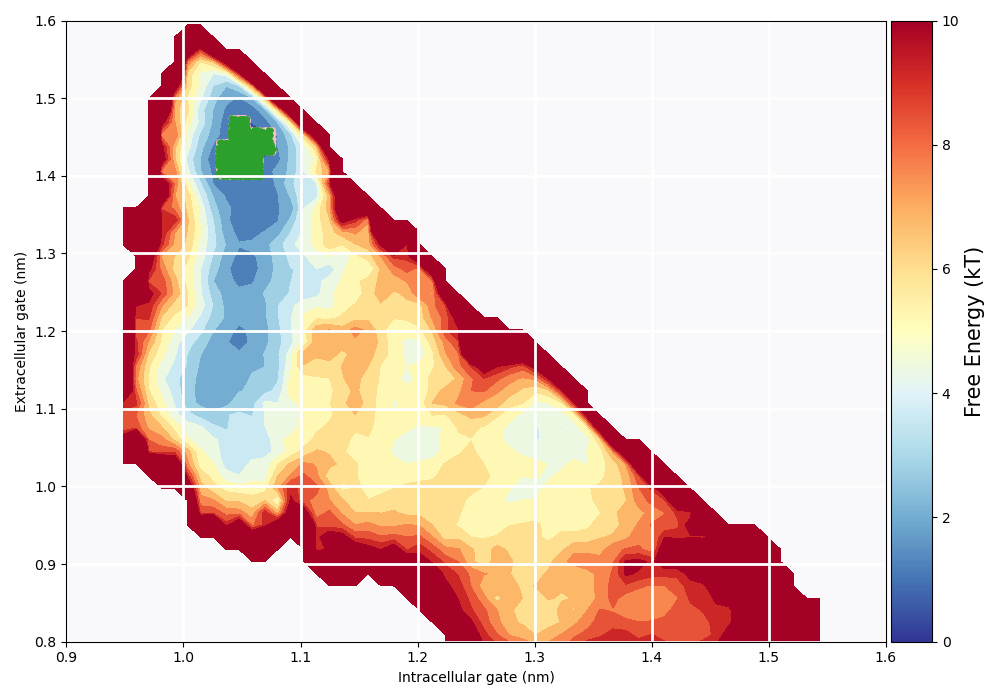

In [95]:
%matplotlib widget

test_IC = np.loadtxt(f'{confout_path}/FES_grid_all.IC_gate.xvg')[:,1]
test_EC = np.loadtxt(f'{confout_path}/FES_grid_all.EC_gate.xvg')[:,1]

f_max = 10


fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= xlim,
    ylim= ylim
)

fig.tight_layout()


ax.scatter(all_min_vals[:,0], all_min_vals[:,1])
ax.scatter(all_min_vals_selected_region[:,0], all_min_vals_selected_region[:,1])
ax.scatter(all_nearby_minima_square[:,0], all_nearby_minima_square[:,1], s = 5, alpha = 0.5, c = 'pink')
ax.scatter(test_IC, test_EC,s = 5)

I used to just select 1 square, but I think it's better to have the minimum and make a square of this

In [110]:
IC_leftmost = 1.078
IC_rightmost = 1.093
EC_lowermost = 1.060
EC_uppermost = 1.072

data = cv_proj[:,1,:] ## take only drift value of strings, removing the start of each string

IC_selected_region, EC_selected_region = get_square(data = data,
                                                    IC_leftmost=IC_leftmost,
                                                    IC_rightmost=IC_rightmost,
                                                    EC_lowermost=EC_lowermost,
                                                    EC_uppermost=EC_uppermost,
                                                    IC_index=0,
                                                    EC_index=1)